In [15]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
import matplotlib 

from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.table import Table, join

bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'
from dustmaps.bayestar import BayestarQuery

vergely_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5'
from dustmaps.vergely2022 import Vergely2022Query

In [16]:
distance = np.linspace(0, 1000, 150)

l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 200)
b_ = np.linspace(b0 - 9., b0 + 9., 250)
l, b, d = np.meshgrid(l_, b_, distance, indexing = 'xy')

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')

In [17]:
vergelyquery = Vergely2022Query(map_fname = vergely_path)
vergely = vergelyquery(coords) * 1.052180128669157
print(vergely.shape)

shape: (601, 601, 161)
(601, 601, 161)
(250, 200, 150)


In [18]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '../Data/230420_CAResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [19]:
CA_meta['DIST'][CA_meta['DIST'] < 0] = 0
verg_stars = np.zeros((len(CA_meta), len(distance)))
for i, star in enumerate(CA_meta):
    dinds = distance < star['DIST']

    verg_star = vergelyquery(SkyCoord(star['GLON'] * u.deg, star['GLAT']*u.deg, 
                                    distance=distance[dinds]*u.pc, frame = 'galactic')) 
    verg_stars[i, dinds ] = verg_star * 1.052180128669157
verg_reddening = np.sum(verg_stars, axis = 1) * 5

In [20]:
lambda0 = 15272.42 
sigma0 = 1.37

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [21]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

def find_nearest(ll, bb):
    l_sel = l_
    b_sel = b_

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)

In [22]:
res_array = np.zeros((len(CA_meta), len(wavs_window)))
res_err_array = np.zeros(res_array.shape)
dustmaps_inds = np.zeros((len(CA_meta), 3)).astype(int)

for i in range(len(CA_meta)):
    star = CA_meta[i]
    try:
        res_hdu = fits.open(get_ca_res(star['FILE']))
        res_array[i, :] = res_hdu[1].data[window]
        res_err_array[i, :] = res_hdu[2].data[window]
    except:
        res_array[i, :] = np.nan
        res_err_array[i, :] = np.nan

    try:
        l_ind, b_ind = find_nearest(star['GLON'], star['GLAT'])
        d_ind = find_nearest_dist(star['DIST'])
        dustmaps_inds[i, :] = np.array((l_ind, b_ind, d_ind)) #remember that the two indices switch
    except:
        dustmaps_inds[i, :] = 0

/tmp/ipykernel_3102065/2399489081.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dustmaps_inds[i, :] = np.array((l_ind, b_ind, d_ind)) #remember that the two indices switch


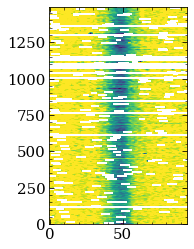

In [23]:
plt.imshow(res_array, origin = 'lower', aspect = .1, vmin = 0.95, vmax = 1)

In [24]:
def gaussian(x, x0, sigma, A):
    return A * np.exp(-(x-x0)**2 / (2 * sigma**2))

fit_params = np.zeros((len(CA_meta), 3))
fit_errs = np.zeros((len(CA_meta), 3))
for i in range(len(res_array)):
    res = res_array[i, :]
    res_mask = np.isnan(res_array[i, :])
    res = np.ma.array(res, mask = res_mask)
    res_err = np.ma.array(res_err_array[i, :], mask = res_mask)
    wavs_fit = np.ma.array(wavs_window, mask = res_mask)

    try:
        outputs = curve_fit(gaussian, wavs_fit, 1-res, sigma = res_err, p0 = (lambda0, sigma0, 0.025), 
                            bounds = ((lambda0-5, 0.7, 0), (lambda0+5, 3.4, 0.1)), check_finite = False)
        fit_params[i, :] = outputs[0]
        fit_errs[i, :] = np.sqrt(np.diag(outputs[1]))
    except:
        fit_params[i, :] = np.nan
        fit_errs[i, :] = np.nan
    

/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/scipy-1.8.0-py3.10-linux-x86_64.egg/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


In [25]:
eqw_interp = np.trapz(1-res_array, x = wavs_window[np.newaxis, :], axis = 1)
eqw_interp_err = np.sqrt(np.sum(res_err_array**2, axis = 1) )

In [26]:
eqw_interp

array([0.16308084, 0.09211305, 0.15090753, ..., 0.05822225, 0.04454868,
       0.08098006])

In [27]:
eqw = np.sqrt(2 * np.pi) * fit_params[:, 2] * fit_params[:, 1]
eqw_err = np.sqrt(fit_errs[:, 2]**2 + fit_errs[:, 1]**2)

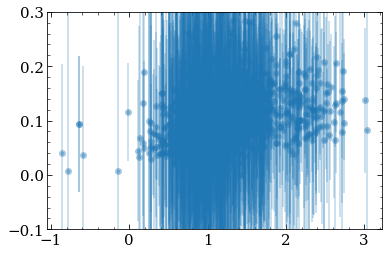

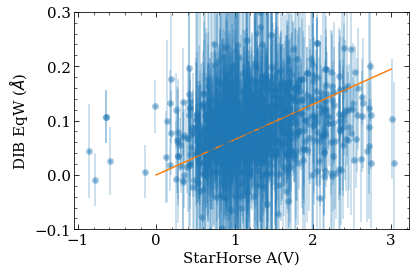

In [28]:
fig, ax = plt.subplots()
ax.scatter(CA_meta['AV50'], eqw, alpha = 0.3)
ax.errorbar(CA_meta['AV50'], eqw, yerr = eqw_err, fmt='.', alpha = 0.3)
ax.set_ylim(-0.1, 0.3)
plt.show

line = lambda x, m : m * x 
fig, ax = plt.subplots()
ax.scatter(CA_meta['AV50'], eqw_interp, alpha = 0.3)
ax.errorbar(CA_meta['AV50'], eqw_interp, yerr = eqw_interp_err, fmt='.', alpha = 0.3)
ax.set_ylim(-0.1, 0.3)

eqw_interp_mask = (np.isnan(eqw_interp)  | np.isnan(eqw_interp_err) | np.isnan(CA_meta['AV50']) ) == False
eqw_interp_fit = eqw_interp[eqw_interp_mask]
eqw_err_fit = eqw_interp_err[eqw_interp_mask]
av_fit = CA_meta['AV50'].data[eqw_interp_mask]
line_fit = curve_fit(line, av_fit, eqw_interp_fit, sigma = eqw_err_fit, check_finite = True,
                     p0 = (0.2), bounds = ((0), (5)))
ax.plot([0, 3], [0, 3 * line_fit[0][0]])
ax.set_xlabel('StarHorse A(V)')
ax.set_ylabel('DIB EqW ($\AA$)')

plt.show()

# ax.set_xlim(200, 800)

In [29]:
np.nanmedian(fit_params[:, 1])

1.3344221654427373

(array([121.,  42.,  61.,  96., 127., 142., 142., 142., 126.,  89.,  82.,
         64.,  42.,  36.,  20.,  20.,  22.,   8.,   8.,   6.,   9.,   7.,
          5.,   5.,   4.,   2.,   4.,   5.,   3.,  47.]),
 array([0.7 , 0.79, 0.88, 0.97, 1.06, 1.15, 1.24, 1.33, 1.42, 1.51, 1.6 ,
        1.69, 1.78, 1.87, 1.96, 2.05, 2.14, 2.23, 2.32, 2.41, 2.5 , 2.59,
        2.68, 2.77, 2.86, 2.95, 3.04, 3.13, 3.22, 3.31, 3.4 ]),
 <BarContainer object of 30 artists>)

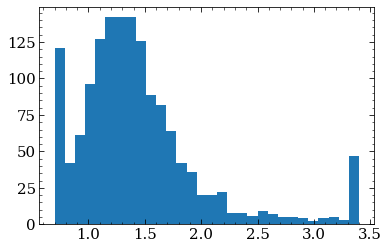

In [30]:
plt.hist(fit_params[:, 1], bins = 30)

In [31]:
line_fit[0][0] / (np.sqrt(2 * np.pi) * np.nanmedian(fit_params[:, 1])) 

0.019396791962720338

In [32]:
np.sqrt(np.diag(line_fit[1]))

array([0.00135923])

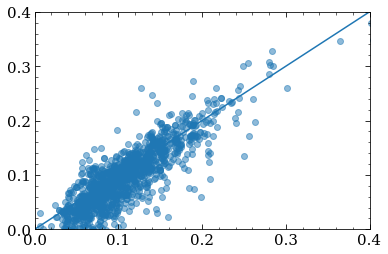

In [33]:
fig, ax = plt.subplots()
ax.scatter(eqw, eqw_interp, alpha = 0.5)
ax.plot([0, 0.4], [0, 0.4])
ax.set_xlim(0, 0.4)
ax.set_ylim(0, 0.4)
plt.show()

In [34]:
def select_stars(tab, l0, b0, radius = .4):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

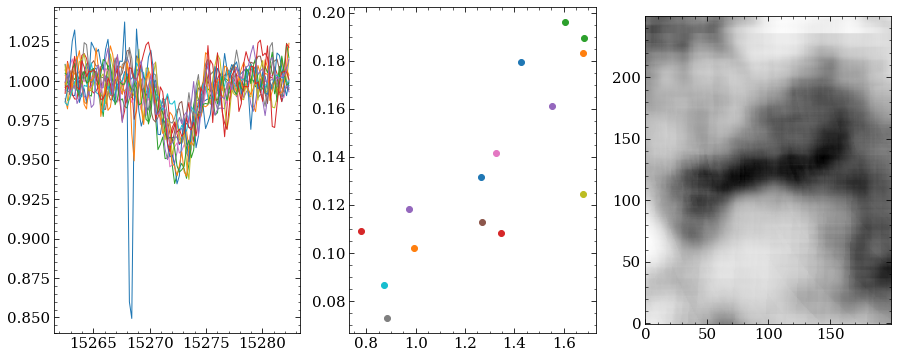

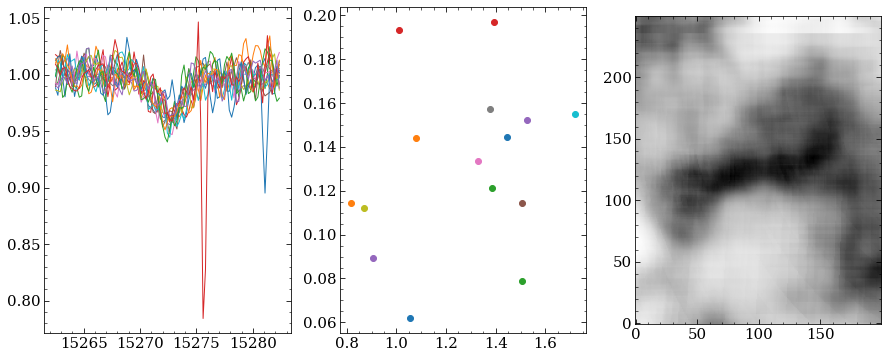

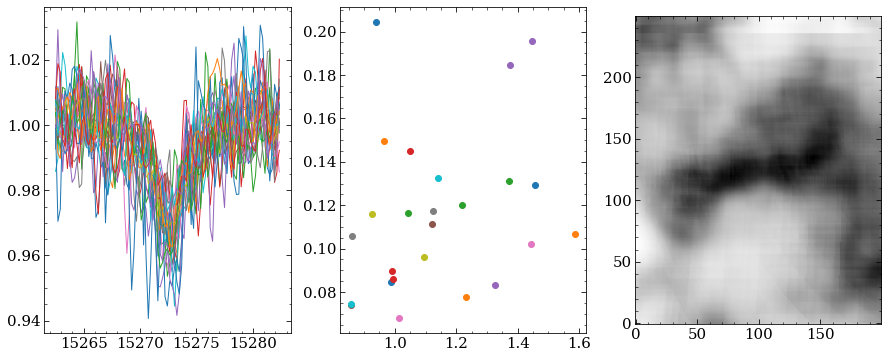

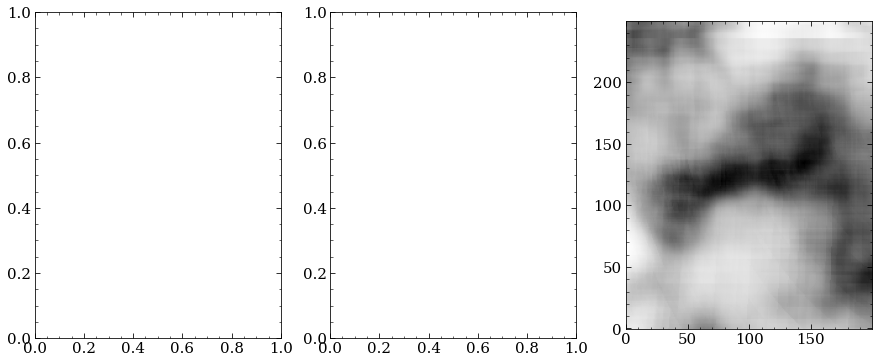

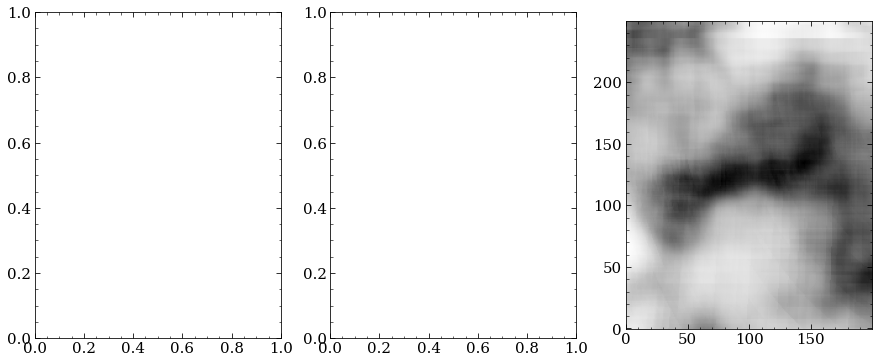

In [42]:
def plots(tab, l0, b0,):
    inds = select_stars(tab, l0, b0)
    stars = tab[inds]
    DIBs = res_array[inds, :]
    ERRs = res_err_array[inds, :]
    eqws = eqw[inds]
    ext = verg_reddening[inds]

    fig, axs= plt.subplots(nrows = 1, ncols = 3, figsize = (15,6))
    for i in range(len(inds)):
        axs[0].plot(wavs_window, DIBs[i,:], linewidth = 1)
        axs[1].scatter(ext[i], eqws[i])
    # axs[1].scatter(stars['AV50'], eqws)

    axs[2].imshow(np.sum(vergely, axis = 2) * 5, origin = 'lower', cmap = 'binary', extent = extent)
    plt.show()
plots(CA_meta, l0, b0)
plots(CA_meta, l0+1, b0)
plots(CA_meta, l0, b0+1)
plots(CA_meta, l0+5, b0)
plots(CA_meta, l0, b0+5)

In [36]:
CA_meta['AV50']

2.245953
2.0011132
--
1.5371506
1.9309561
--
1.9841846
2.1325636
2.4812884
1.6385014
--
